Livrable 2 - Débruitage

In [1]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Dense, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy
import os
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import keras_tuner as kt
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
# Téléchargement et extraction des données
DATASET_PATH = os.path.join("dataset")

# Définition du chemin de base de votre dataset
base_dataset_path = os.path.join("dataset", "Projet-DataScientist-master")

dataset_category_path = os.path.join(base_dataset_path,"dataset")

def fetch_data():
    DOWNLOAD_ROOT = "https://github.com/gamaticow/Projet-DataScientist/archive/refs/heads/master.zip"
    if not os.path.isdir(DATASET_PATH):
        os.makedirs(DATASET_PATH)
        urllib.request.urlretrieve(DOWNLOAD_ROOT, "dataset/dataset.zip")
    if not os.path.isdir(base_dataset_path):
        with zipfile.ZipFile("dataset/dataset.zip","r") as zip_ref:
                zip_ref.extractall(DATASET_PATH)

# Appel de la fonction pour télécharger et extraire les données
fetch_data()

# Parcourir les catégories de votre dataset
categories = [d for d in os.listdir(base_dataset_path) if os.path.isdir(os.path.join(base_dataset_path, d))]

In [3]:
image_size = 224
batch_size = 32
epochs= 100
latent_dim = 64  # Dimension de l'espace latent

def charger_images(dossier, taille=(image_size, image_size)):
    images = []
    for fichier in os.listdir(dossier):
        if fichier.endswith('.jpg'):
            img = imread(os.path.join(dossier, fichier))
            img = resize(img, taille, anti_aliasing=True)
            if img.shape == (taille[0], taille[1], 3):  # Ensure the image has the correct shape
                images.append(img)
            else:
                print(f"Skipping file {fichier} due to inconsistent shape: {img.shape}")
    return np.array(images, dtype=np.float32)

In [4]:
def ajouter_bruit(images, facteur_bruit=0.4):  
    bruit = np.random.normal(loc=0.0, scale=facteur_bruit, size=images.shape)  
    images_bruitees = images + bruit
    images_bruitees = np.clip(images_bruitees, 0., 1.)
    return images_bruitees

In [5]:
def convertir_en_niveaux_de_gris(images):
    return np.array([rgb2gray(img) for img in images])

In [6]:
def display_image(X, n):
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1) #A COMPLETER
        plt.imshow(X[i].reshape(image_size, image_size, 3)) #A COMPLETER
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [7]:
def evaluate_image_quality(original_images, denoised_images):
    assert original_images.shape == denoised_images.shape, "Original and denoised images must have the same dimensions"
    
    # Ensure data types match and are scaled appropriately
    # original_images = original_images.astype('float32') / 255.0
    # denoised_images = denoised_images.astype('float32') / 255.0

    psnr_scores = []
    ssim_scores = []
    for original, denoised in zip(original_images, denoised_images):
        p = psnr(original, denoised, data_range=1.0)  # Set data range for normalized images
        s = ssim(original, denoised, data_range=1.0, multichannel=True, channel_axis=2)  # Set data range and specify channel axis
        psnr_scores.append(p)
        ssim_scores.append(s)
    return np.mean(psnr_scores), np.mean(ssim_scores)

In [8]:
def build_model_tuning(hp):
        input_img = Input(shape=(image_size, image_size, 3))
        
        # Encoder
        x = Conv2D(hp.Int('encoder_conv1_filters', min_value=32, max_value=128, step=32),
                (3, 3), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(hp.Int('encoder_conv2_filters', min_value=32, max_value=64, step=32),
                (3, 3), activation='relu', padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        # Decoder
        x = Conv2D(hp.Int('decoder_conv1_filters', min_value=32, max_value=64, step=32),
                (3, 3), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(hp.Int('decoder_conv2_filters', min_value=32, max_value=128, step=32),
                (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

        model = Model(input_img, decoded)
        model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

        return model

In [9]:
def build_model():
    input_img = Input(shape=(image_size, image_size, 3))

    # Encoder
    x = Conv2D(190, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(160, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(160, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(190, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(input_img, decoded)
    # optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer='adam', loss='mse', metrics=["accuracy"])

    return model

In [10]:
# Pour VAE    
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Ajoutez les variables z_mean et z_log_var à l'objet pour un accès ultérieur
        self.add_loss(self.vae_loss(inputs, reconstructed, z_mean, z_log_var))
        return reconstructed

    def vae_loss(self, inputs, reconstructed, z_mean, z_log_var):
        reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(reconstructed))
        reconstruction_loss *= image_size * image_size  # Pour compenser la moyenne de binary_crossentropy
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        return K.mean(reconstruction_loss + kl_loss)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstructed = self.decoder(z)
            loss = self.vae_loss(data, reconstructed, z_mean, z_log_var)
        
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {'loss': loss}

# Utilisation d'un échantillonneur pour le goulot d'étranglement
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [11]:
# Définir le générateur avec des transformations pour l'augmentation
data_gen_args = dict(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

def generate_data(image_generator, mask_generator):
    while True:
        x_batch, y_batch = [], []
        # Accumuler des lots de la taille spécifiée
        for _ in range(batch_size):
            x, y = next(image_generator), next(mask_generator)
            x_batch.append(x[0])  # x[0] parce que flow retourne (images, labels)
            y_batch.append(y[0])  # y[0] pour la même raison

        # Concaténer les listes en un seul batch
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)
        yield (x_batch, y_batch)

In [12]:
images_non_bruitees = charger_images(dataset_category_path)

images_bruitees = ajouter_bruit(images_non_bruitees)

images_non_bruitees_train, images_non_bruitees_test, images_bruitees_train, images_bruitees_test = train_test_split(images_non_bruitees, images_bruitees, test_size=0.2)

images_non_bruitees = images_non_bruitees.astype('float32') / 255.0
images_bruitees = images_bruitees.astype('float32') / 255.0

images_non_bruitees_train = np.reshape(images_non_bruitees_train, (len(images_non_bruitees_train), image_size, image_size, 3))
images_non_bruitees_test = np.reshape(images_non_bruitees_test, (len(images_non_bruitees_test), image_size, image_size, 3))
images_bruitees_train = np.reshape(images_bruitees_train, (len(images_bruitees_train), image_size, image_size, 3))
images_bruitees_test = np.reshape(images_bruitees_test, (len(images_bruitees_test), image_size, image_size, 3))



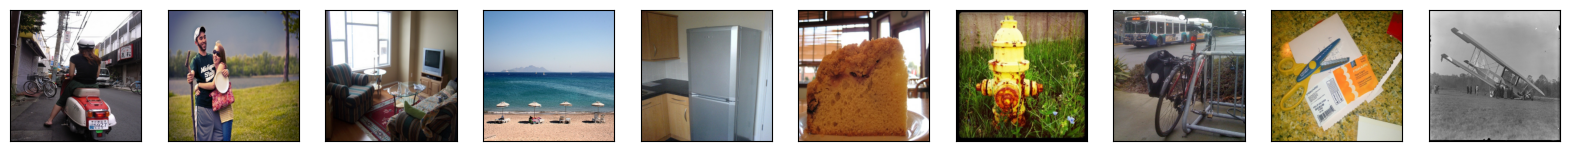

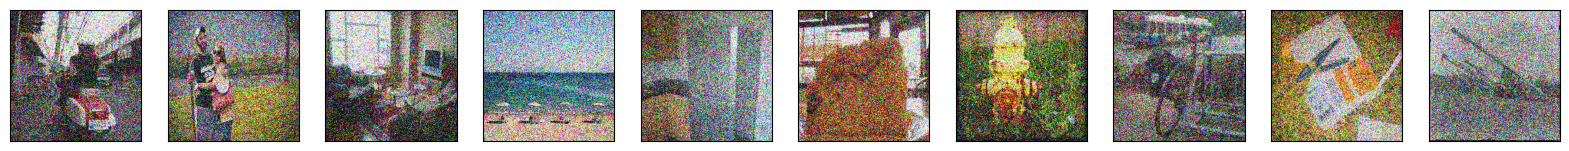

In [13]:
display_image(images_non_bruitees_train, 10)
display_image(images_bruitees_train, 10) #A COMPLETER


In [14]:
tuning = False
vae = False

if tuning:
    # Configure the tuner
    tuner = kt.Hyperband(build_model_tuning,
                        objective='val_loss',
                        max_epochs=10,
                        factor=3,
                        directory='my_dir',
                        project_name='denoising_autoencoder')

    # Load your image data
    # images_non_bruitees_train, images_bruitees_train, etc. need to be predefined

    # Run the hyperparameter search
    tuner.search(images_bruitees_train, images_non_bruitees_train,
                validation_data=(images_bruitees_test, images_non_bruitees_test),
                epochs=10,
                batch_size=batch_size)

    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"""
    The best number of filters for the first encoder convolutional layer is {best_hps.get('encoder_conv1_filters')}
    and for the second encoder convolutional layer is {best_hps.get('encoder_conv2_filters')}.
    The best number of filters for the first decoder convolutional layer is {best_hps.get('decoder_conv1_filters')}
    and for the second decoder convolutional layer is {best_hps.get('decoder_conv2_filters')}.
    """)
    
    model = tuner.hypermodel.build(best_hps)
elif vae:
    # Encodeur
    inputs = Input(shape=(image_size, image_size, 3), name='encoder_input')
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    shape = K.int_shape(x)

    x = Flatten()(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # Décodeur
    decoder_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(decoder_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
    outputs = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Instanciation des modèles
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    decoder = Model(decoder_inputs, outputs, name='decoder')

    # Modèle VAE
    outputs = decoder(encoder(inputs)[2])
    model = VAE(encoder, decoder)
    model.compile(optimizer='adam')
else:
    image_datagen = ImageDataGenerator(**data_gen_args)
    image_generator = image_datagen.flow(images_bruitees_train, batch_size=batch_size)

    # Puisque les labels (images non bruitées) ne doivent pas être augmentés de manière à déformer leurs valeurs,
    # on ne leur applique aucune transformation.
    mask_datagen = ImageDataGenerator()
    mask_generator = mask_datagen.flow(images_non_bruitees_train, batch_size=batch_size)

    # Combiner les générateurs pour produire des paires (image bruitée, image originale)
    train_generator = generate_data(image_generator, mask_generator)
    test_x, test_y = next(train_generator)
    print(test_x.shape, test_y.shape)
    model = build_model()

(32, 224, 224, 3) (32, 224, 224, 3)


In [15]:
if not tuning and not vae:
    history = model.fit(train_generator, 
                        steps_per_epoch=len(images_bruitees_train) // batch_size,
                        epochs=epochs,
                        validation_data=(images_bruitees_test, images_non_bruitees_test),
                        validation_steps=len(images_bruitees_test) // batch_size)
else:
    history = model.fit(images_bruitees_train, images_non_bruitees_train, 
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(images_bruitees_test, images_non_bruitees_test))

Num GPUs Available:  0
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 13s/step - accuracy: 0.2858 - loss: 0.0712 - val_accuracy: 0.4376 - val_loss: 0.0802
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 44s 15s/step - accuracy: 0.4232 - loss: 0.0760 - val_accuracy: 0.2343 - val_loss: 0.0795
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 16s/step - accuracy: 0.3194 - loss: 0.0764 - val_accuracy: 0.4342 - val_loss: 0.0799
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 44s 15s/step - accuracy: 0.4618 - loss: 0.0752 - val_accuracy: 0.4375 - val_loss: 0.0794
Epoch 5/100
2/3 ━━━━━━━━━━━━━━━━━━━━ 14s 15s/step - accuracy: 0.5178 - loss: 0.0766

: 

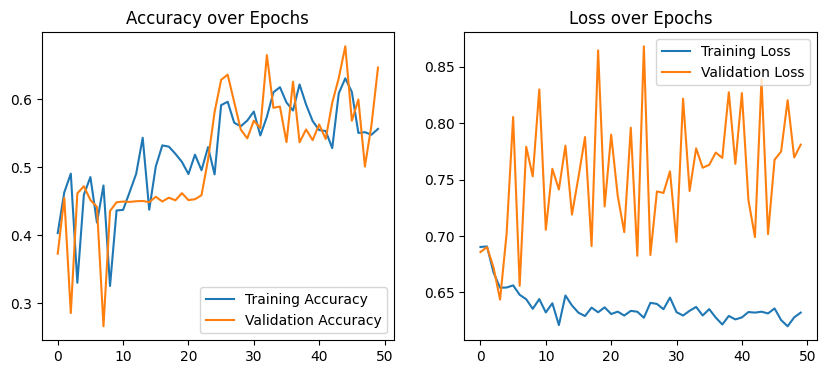

In [ ]:
# Visualisation des résultats de l'entraînement
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


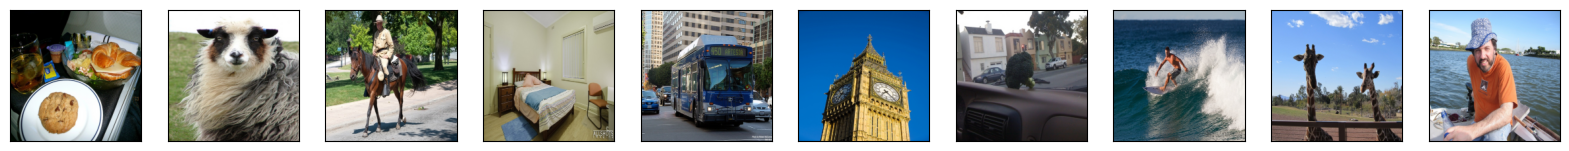

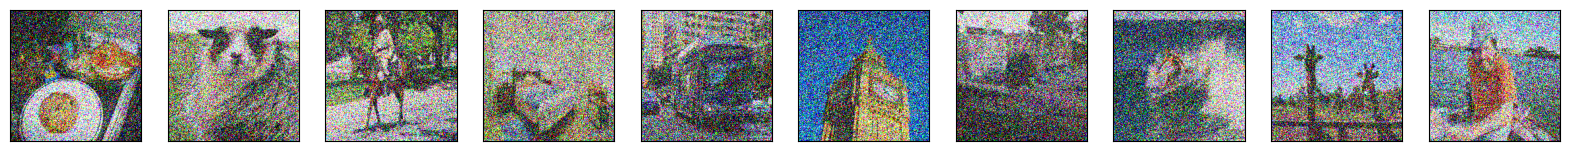

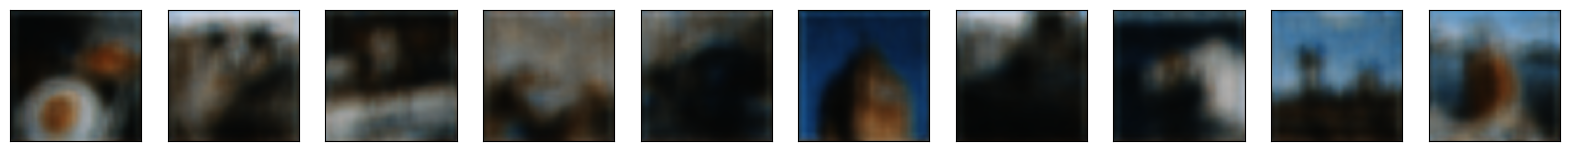

In [ ]:
decoded_imgs = model.predict(images_bruitees_test)

display_image(images_non_bruitees_test, 10)
display_image(images_bruitees_test, 10)
display_image(decoded_imgs, 10)

In [ ]:
try:
    print(images_non_bruitees_test[0].shape)
    psnr_score, ssim_score = evaluate_image_quality(images_non_bruitees_test, decoded_imgs)  # Adjust win_size as necessary
    print(f"Average PSNR: {psnr_score}")
    print(f"Average SSIM: {ssim_score}")
except ValueError as e:
    print(e)

(200, 200, 3)
Average PSNR: 10.37371706000995
Average SSIM: 0.26239144802093506
